### Importing Packages

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

### Downloading MNIST dataset from Kaggle

In [0]:
!pip install kaggle

    100% |████████████████████████████████| 61kB 6.0MB/s 
    100% |████████████████████████████████| 235kB 9.6MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/8b/21/3b/a0076243c6ae12a6215b2da515fe06b539aee7217b406e510e
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c digit-recognizer

 93% 68.0M/73.2M [00:01<00:00, 34.0MB/s]
100% 73.2M/73.2M [00:01<00:00, 55.2MB/s]
 86% 42.0M/48.8M [00:01<00:00, 23.6MB/s]
100% 48.8M/48.8M [00:01<00:00, 45.1MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 53.6MB/s]


### Loading and setting up data

In [0]:
def load_dataset():
    training_data = pd.read_csv("train.csv", sep=',')

    train_x_orig = training_data.head(30000).iloc[:, 1:785]
    train_y = training_data.head(30000).iloc[:, 0]

    test_x_orig = training_data.tail(12000).iloc[:, 1:785]
    test_y = training_data.tail(12000).iloc[:, 0]

    train_x_orig = train_x_orig.as_matrix().reshape(30000, 784)
    test_x_orig = test_x_orig.as_matrix().reshape(12000, 784)
    
    return train_x_orig, train_y, test_x_orig, test_y

In [0]:
train_x_orig, train_y, test_x_orig, test_y = load_dataset()

train_x = train_x_orig.astype('float32')
test_x = test_x_orig.astype('float32')

m_train = train_x_orig.shape[0]
m_test = test_x_orig.shape[0]
num_px = int(np.sqrt(train_x_orig.shape[1]))

print("Number of training examples: m_train = " + str(m_train))
print("Number of testing examples: m_test = " + str(m_test))
print("Height/Width of each image: num_px = " + str(num_px))
print("Image size: (" + str(num_px) + ", " + str(num_px) + ")")
print("train_x shape: " + str(train_x_orig.shape))
print("train_y shape: " + str(train_y.shape))
print("test_x shape: " + str(test_x_orig.shape))
print("test_y shape: " + str(test_y.shape))

Number of training examples: m_train = 30000
Number of testing examples: m_test = 12000
Height/Width of each image: num_px = 28
Image size: (28, 28)
train_x shape: (30000, 784)
train_y shape: (30000,)
test_x shape: (12000, 784)
test_y shape: (12000,)


### Visualizing data

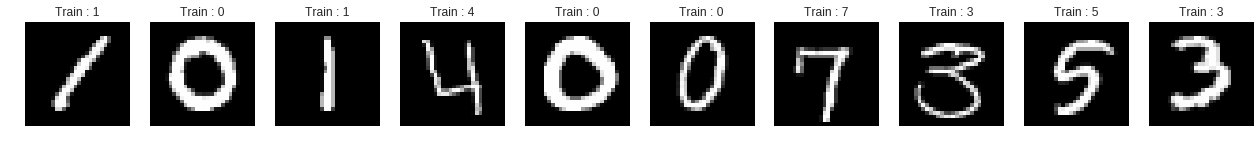

In [0]:
plt.figure(figsize = (22,2))

for index, (image, label) in enumerate(zip(train_x[0:10], train_y[0:10])):
    plt.subplot(1, 10, index+1)
    plt.imshow(np.reshape(image, (28,28)), cmap = plt.cm.gray)
    plt.axis('off')
    plt.title("Train : " + str(label), fontsize = 12)

### Reshaping and Normalization

In [0]:
train_x = train_x_orig.T
test_x = test_x_orig.T
train_y = train_y.as_matrix().reshape(1, 30000)
test_y = test_y.as_matrix().reshape(1, 12000)    

print("train_x shape: " + str(train_x.shape))
print("test_x shape: " + str(test_x.shape))
print("train_y shape: " + str(train_y.shape))
print("test_y shape: " + str(test_y.shape))

train_x shape: (784, 30000)
test_x shape: (784, 12000)
train_y shape: (1, 30000)
test_y shape: (1, 12000)


In [0]:
train_x = train_x / 255
test_x = test_x / 255

### Changing Y in a 10D vector

In [0]:
y_vector = np.array([0,1,2,3,4,5,6,7,8,9]).reshape(10,1)
    
train_y_orig = np.array(train_y)   
train_y = (y_vector == train_y)

## Deep Neural Network Model for Digit Recognition

### Initializing Parameters

In [0]:
def init_params(dims):
    params = {}
    
    for i in range (1, len(dims)):
        if(len(dims) <= 3):
            params["W" + str(i)] = np.random.randn(dims[i], dims[i-1]) * 0.01 
        else:
            params["W" + str(i)] = np.random.randn(dims[i], dims[i-1]) / np.sqrt(dims[i-1])
        
        params["b" + str(i)] = np.zeros((dims[i], 1))
    
    return params

### Activation functions (For forward propagation)

In [0]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [0]:
def relu(z):
    return np.maximum(0, z)

### Forward Propagation

In [0]:
def forward_prop(X, params):
    L = len(params) // 2
    A = X
    caches = []
    
    for i in range(1, L+1):
        A_prev = A
        
        W = params["W" + str(i)]
        b = params["b" + str(i)]
                   
        Z = np.dot(W, A_prev) + b
        linear_cache = (A_prev, W, b)
        
        if(i == L):
            A = sigmoid(Z)
        else:
            A = relu(Z)
        
        activation_cache = Z
        
        caches.append((linear_cache, activation_cache))
        
    return A, caches

### Compute Cost

In [0]:
def compute_cost(Y, AL):
    m = Y.shape[1]
    
    J = (-1/m) * np.sum(Y * np.log(AL) + (1 - Y) * np.log(1 - AL))
    
    return np.squeeze(J)

### Derivatives of activation function (For backward propagation)


In [0]:
def sigmoid_backward(dA, Z):
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

In [0]:
def relu_backward(dA, Z):
    dZ = np.array(dA, copy=True)
    dZ[Z<=0] = 0
    return dZ

### Backward Propagation

In [0]:
def backward_prop(AL, Y, caches):
    L = len(caches)
    m = AL.shape[1]
    
    grads = {}
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    for i in range(L, 0, -1):
        current_cache = caches[i-1]
        
        linear_cache, activation_cache = current_cache
        
        if(i == L):
            dZ = sigmoid_backward(dAL, activation_cache)
        else:
            dZ = relu_backward(grads["dA" + str(i+1)], activation_cache)
        
        A_prev, W, b = linear_cache
        
        grads["dW" + str(i)] = (1/m) * np.dot(dZ, A_prev.T)
        grads["db" + str(i)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)        
        grads["dA" + str(i)] = np.dot(W.T, dZ)
        
    return grads

### Update Parameters

In [0]:
def update_params(params, grads, learning_rate):
    L = len(params) // 2
    
    for l in range(1, L+1):
        params["W" + str(l)] -= learning_rate * grads["dW" + str(l)]
        params["b" + str(l)] -= learning_rate * grads["db" + str(l)]
        
    return params

### Combining everthing into Multi-layer Neural Network Model

In [0]:
def NN_model(X, Y, dims, learning_rate = 0.3, num_itrs = 3000, print_cost = False):
    params = init_params(dims)
    costs = []
    
    for i in range(num_itrs):   
        AL, caches = forward_prop(X, params)
        #print(AL.shape)
        cost = compute_cost(Y, AL)
        
        grads = backward_prop(AL, Y, caches)
        
        params = update_params(params, grads, learning_rate)
        
        if(i % 50 == 0):
            costs.append(cost)
            
            if(print_cost):
                print("Iteration #%i : %f" % (i, cost))
     
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()
    
    return params

Iteration #0 : 6.928294
Iteration #50 : 1.365624
Iteration #100 : 0.829118
Iteration #150 : 0.661902
Iteration #200 : 0.566558
Iteration #250 : 0.537654
Iteration #300 : 0.529705
Iteration #350 : 0.529134
Iteration #400 : 0.483088
Iteration #450 : 0.472570


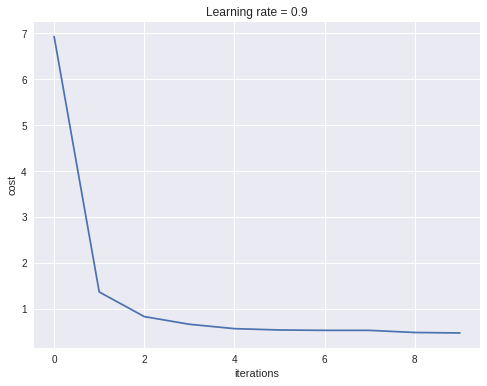

In [0]:
dims = [784, 50, 10]
params1 = NN_model(train_x, train_y, dims, learning_rate = 0.9
                   , num_itrs = 500, print_cost=True)

In [0]:
def predict(X, Y, params):
    y, caches = forward_prop(X, params)
    
    predictions = np.argmax(y, axis=0).reshape(1,X.shape[1])
    
    print("Accuracy : " + str(np.sum((predictions == Y) / X.shape[1])))
    
    return predictions

In [0]:
predictions_train = predict(train_x, train_y_orig, params1)
predictions_test = predict(test_x, test_y, params1)

Accuracy : 0.9350666666666669
Accuracy : 0.9279166666666667


Iteration #0 : 7.145173
Iteration #50 : 1.772275
Iteration #100 : 1.613322
Iteration #150 : 0.435181
Iteration #200 : 0.346957
Iteration #250 : 0.652333
Iteration #300 : 0.520091
Iteration #350 : 0.251605
Iteration #400 : 0.211480
Iteration #450 : 0.610381


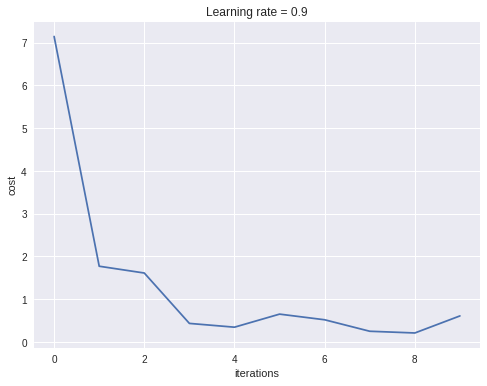

In [0]:
layers_dims = [784, 300, 100, 10]
params = NN_model(train_x, train_y, layers_dims, learning_rate = 0.9, num_itrs = 500, print_cost=True)

In [0]:
pred_train = predict(train_x, train_y_orig, params)
pred_test = predict(test_x, test_y, params)

Accuracy : 0.9600666666666668
Accuracy : 0.9491666666666667


### Misclassified Images

Total number of misclassified examples 610


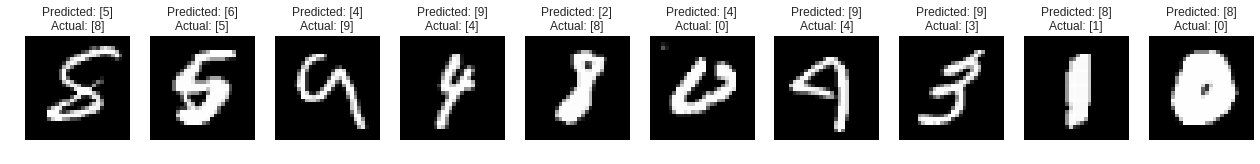

In [0]:
index = 0
misclassified_indexs = []

for actual, predict in zip(test_y[0], pred_test[0]):
    if(actual != predict):
        misclassified_indexs.append(index)
    index += 1


plt.figure(figsize=(22,4))

for i, j in enumerate(misclassified_indexs[0:10]):
    plt.subplot(1, 10, i + 1)
    plt.imshow(np.reshape(test_x[:,j], (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.title('Predicted: {}\nActual: {}'.format(pred_test[:,j], test_y[:,j]), fontsize = 12)
 
print("Total number of misclassified examples", len(misclassified_indexs))